In [1]:
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from dataset import TreeStimuli, Neuron, Ensemble, LinearNeuron, InteractionNeuron,LogisticNeuron, UnivariateGaussianNeuron, MultivariateGaussianNeuron
from copy import deepcopy
from functools import partial

# Synthetic dataset generation

## stimuli space

First we generate a set of tree stimuli of varying leafiness and branchiness. Here we didn't specify the feature vector of leafiness and branchiness, and it will by default create 40 stimuli from factorial combinations of 20 levels of leafiness and 2 levels of branchiness

In [2]:
Trees = TreeStimuli()
Trees.stimuli

array([[0.2 , 0.02],
       [0.2 , 1.  ],
       [0.26, 0.02],
       [0.26, 1.  ],
       [0.32, 0.02],
       [0.32, 1.  ],
       [0.38, 0.02],
       [0.38, 1.  ],
       [0.44, 0.02],
       [0.44, 1.  ],
       [0.5 , 0.02],
       [0.5 , 1.  ],
       [0.56, 0.02],
       [0.56, 1.  ],
       [0.62, 0.02],
       [0.62, 1.  ],
       [0.68, 0.02],
       [0.68, 1.  ],
       [0.74, 0.02],
       [0.74, 1.  ],
       [0.8 , 0.02],
       [0.8 , 1.  ],
       [0.86, 0.02],
       [0.86, 1.  ],
       [0.92, 0.02],
       [0.92, 1.  ],
       [0.98, 0.02],
       [0.98, 1.  ],
       [1.04, 0.02],
       [1.04, 1.  ],
       [1.1 , 0.02],
       [1.1 , 1.  ],
       [1.16, 0.02],
       [1.16, 1.  ],
       [1.22, 0.02],
       [1.22, 1.  ],
       [1.28, 0.02],
       [1.28, 1.  ],
       [1.34, 0.02],
       [1.34, 1.  ]])

## Define different types of neurons and ensembles

One instantiation of the various `**Neuron` class create a neuron with parameterized firing function. Linear/nonlinear pure/mixed selectivity can be achieved by different class and different parameters (see documentation for further details). 

c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

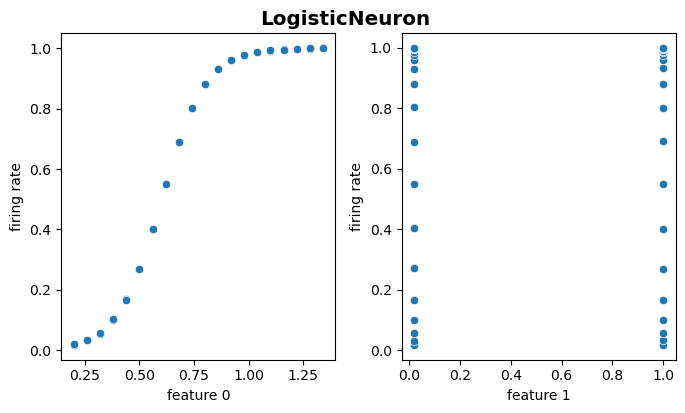

In [3]:
logisiticneuron_param = {"w":np.array([[1],[0]]), "k":10, "x0":0.6}
_ = LogisticNeuron(**logisiticneuron_param).plot_firingrate(Trees.stimuli)

Alternatively, new neuron class can be created as needed.

c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

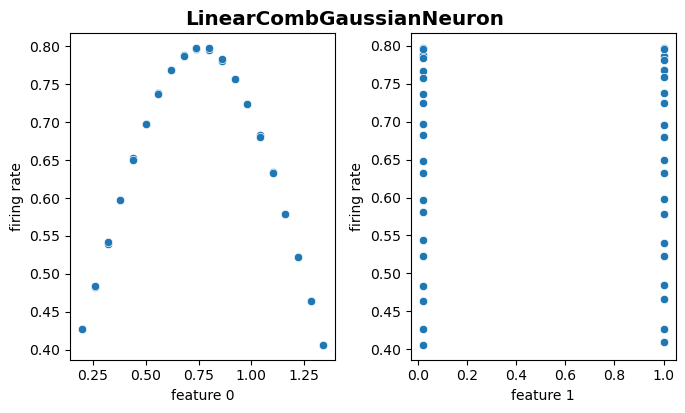

In [4]:
class LinearCombGaussianNeuron(Neuron):
  def __init__(self,w,mus,sigs,noise_mu:int=0,noise_sig:int=0.001) -> None:
    super().__init__(noise_mu,noise_sig)
    gaussians = [partial(lambda x: scipy.stats.norm(mu,sig).pdf(x)) for (mu,sig) in zip([0.33,0.76],[.22,.5])]
    self.activate = lambda stimuli: np.array([gaussian(stimuli[:,j]) for j,gaussian in enumerate(gaussians)]).T@w
    self.firing_description = f"feature weights = {w} \nmultivariate gaussian centered around {mus},\n sigma={sigs} \n"

class LinearCombLogisticNeuron(Neuron):
  def __init__(self,w,ks,x0s,noise_mu=0,noise_sig=1) -> None:
    super().__init__(noise_mu,noise_sig)
    sigmoids = [partial(lambda x: 1/(1+np.exp(-k*(x-x0))))for (k,x0) in enumerate(zip(ks,x0s))]
    self.activate = lambda stimuli: np.array([sigmoid(stimuli[:,j]) for j,sigmoid in enumerate(sigmoids)])@w
    self.firing_description = f"feature weights = {w} \n logistic function k={ks},\n x0={x0s} \n"

lcgauneuron_param = {"w":np.array([[1],[0]]), "mus":[0.33,0.76], "sigs":[0.2,0.5]}
_ = LinearCombGaussianNeuron(**lcgauneuron_param).plot_firingrate(Trees.stimuli)

An ensemble consists of multiple neurons, each with different firing functions. Here we set up different ensembles with either linear/nonlinear pure/mixed selectivity. Each has two neurons, and we can visualize the firing space in 2D and compare with the 2D Tree stimuli space

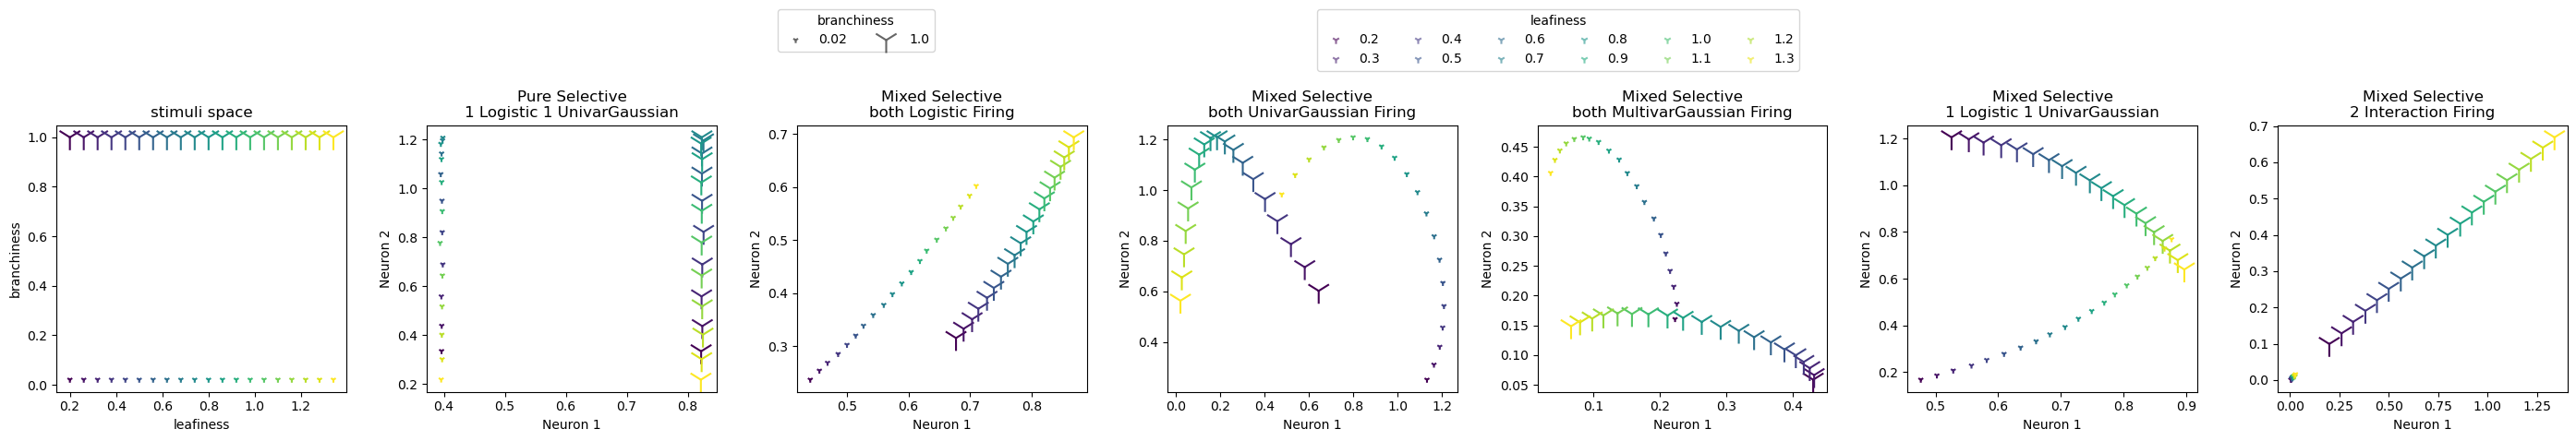

In [5]:
## Ensemble 1:  2 pure selective - logistic+gaussian
classes = [LogisticNeuron,UnivariateGaussianNeuron]
params = [{"w":np.array([[0],[1]]),
           "k":2,
           "x0":0.23},
          {"w":np.array([[1],[0]]),
           "mu":0.73,
           "sig":0.33}]
PureSelectiveMixEnsemble = Ensemble(classes,params)
PureSelectiveMixEnsemble.fire(Trees.stimuli)

## Ensemble 2:  2 mixed selective - logistic
classes = [LogisticNeuron,LogisticNeuron]
params = [{"w":np.array([[0.5],[0.5]]),
           "k":2,
           "x0":0.23},
          {"w":np.array([[0.7],[0.2]]),
           "k":2,
           "x0":0.73}]
MixSelectiveLogisticEnsemble = Ensemble(classes,params)
MixSelectiveLogisticEnsemble.fire(Trees.stimuli)

## Ensemble 3:  2 mixed selective - univariate gaussian
classes = [UnivariateGaussianNeuron,UnivariateGaussianNeuron]
params = [{"w":np.array([[0.5],[0.5]]),
           "mu":0.23,
           "sig":0.33},
          {"w":np.array([[0.7],[0.2]]),
           "mu":0.73,
           "sig":0.33}]
MixSelectiveUGaussianEnsemble = Ensemble(classes,params)
MixSelectiveUGaussianEnsemble.fire(Trees.stimuli)

## Ensemble 4:  2 mixed selective - multivariate gaussian
classes = [MultivariateGaussianNeuron,MultivariateGaussianNeuron]
params = [{"mus":[0.23,0.73],
           "cov":0.33},
          {"mus":[1.04,0.17],
           "cov":0.33}]
MixSelectiveMGaussianEnsemble = Ensemble(classes,params)
MixSelectiveMGaussianEnsemble.fire(Trees.stimuli)


## Ensemble 5:  2 mixed selective - logistic+gaussian
classes = [LogisticNeuron,UnivariateGaussianNeuron]
params = [{"w":np.array([[0.9],[0.1]]),
           "k":2,
           "x0":0.23},
          {"w":np.array([[0.3],[0.7]]),
           "mu":0.73,
           "sig":0.33}]
MixSelectiveMixEnsemble = Ensemble(classes,params)
MixSelectiveMixEnsemble.fire(Trees.stimuli)


## Ensemble 6:  2 interactioin neuron
classes = [InteractionNeuron,InteractionNeuron]
params = [{"w":1,
           },
          {"w":0.5,
           }]
MixSelectiveInteractionEnsemble = Ensemble(classes,params)
MixSelectiveInteractionEnsemble.fire(Trees.stimuli)

TwoNeuronSpaces = {
    "stimuli space":Trees.stimuli,
    "Pure Selective - 1 Logistic 1 UnivarGaussian":PureSelectiveMixEnsemble.fire(Trees.stimuli),
    "Mixed Selective - both Logistic Firing": MixSelectiveLogisticEnsemble.fire(Trees.stimuli),
    "Mixed Selective - both UnivarGaussian Firing": MixSelectiveUGaussianEnsemble.fire(Trees.stimuli),
    "Mixed Selective - both MultivarGaussian Firing": MixSelectiveMGaussianEnsemble.fire(Trees.stimuli),
    "Mixed Selective - 1 Logistic 1 UnivarGaussian": MixSelectiveMixEnsemble.fire(Trees.stimuli),
    "Mixed Selective - 2 Interaction Firing": MixSelectiveInteractionEnsemble.fire(Trees.stimuli),
}

fig_fspace,ax_fspace = plt.subplots(1,len(TwoNeuronSpaces),figsize=(4*(len(TwoNeuronSpaces)),4))
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    splot=ax_fspace[js].scatter(x=s_mat[:,0],y=s_mat[:,1],c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax_fspace[js].set_title(s_name.replace(' - ','\n'))
    if "stimuli" in s_name:
        ax_fspace[js].set_xlabel(Trees.featurenames[0])
        ax_fspace[js].set_ylabel(Trees.featurenames[1])
    else:
        ax_fspace[js].set_xlabel("Neuron 1")
        ax_fspace[js].set_ylabel("Neuron 2")
hs, ls = splot.legend_elements(prop="sizes", alpha=0.6)
ls = np.unique(Trees.stimuli[:,1])#use original feature value as label
hc, lc = splot.legend_elements(prop="colors", alpha=0.6)
fig_fspace.legend(hs,ls, loc='outside upper left',bbox_to_anchor=(0.3,1.2),ncol=6, title=Trees.featurenames[1])
fig_fspace.legend(hc,lc, loc='outside upper right',bbox_to_anchor=(0.7,1.2),ncol=6, title=Trees.featurenames[0])
fig_fspace.tight_layout()

contour plots can help visualize the firing landscape of the neurons

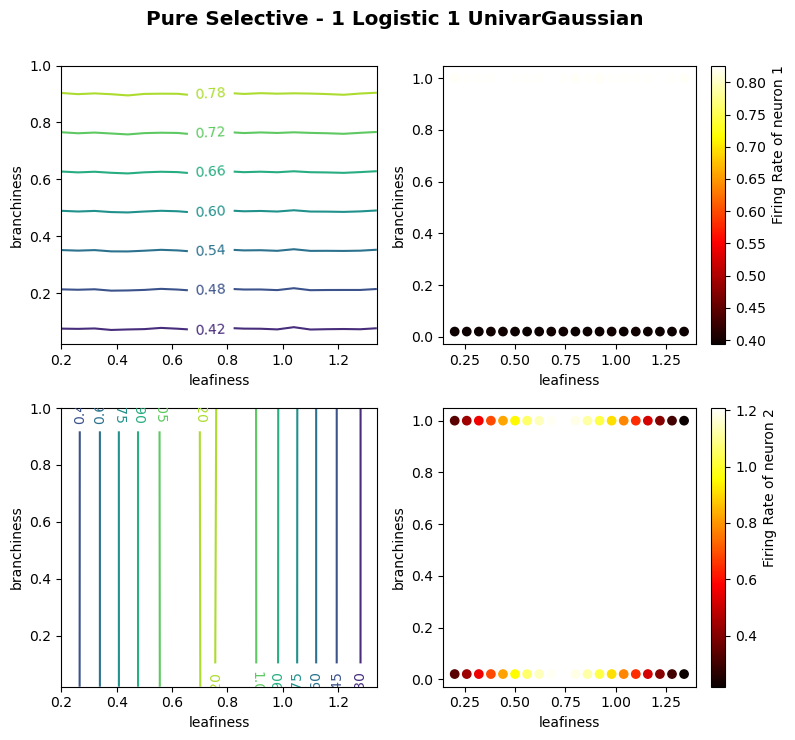

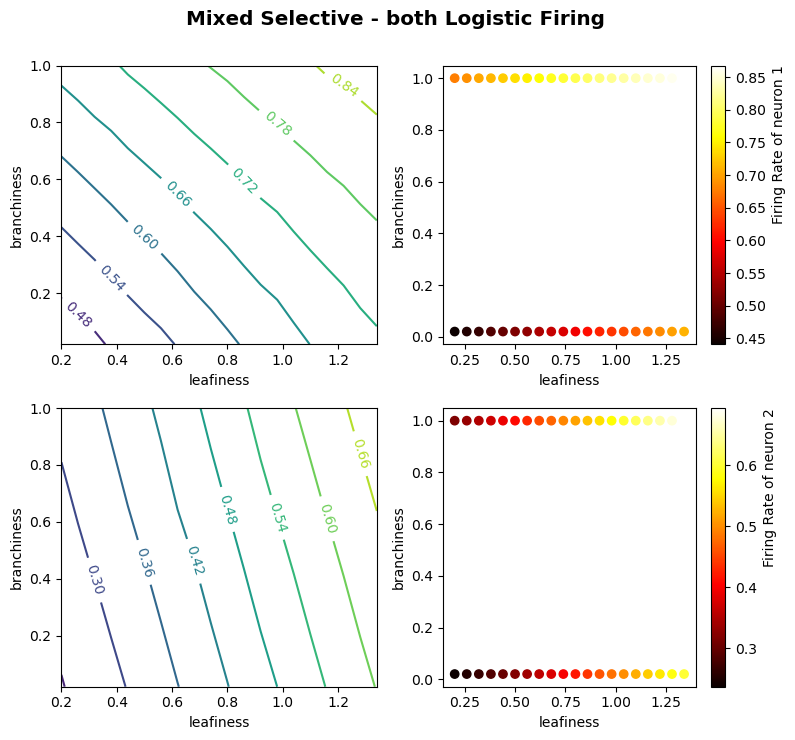

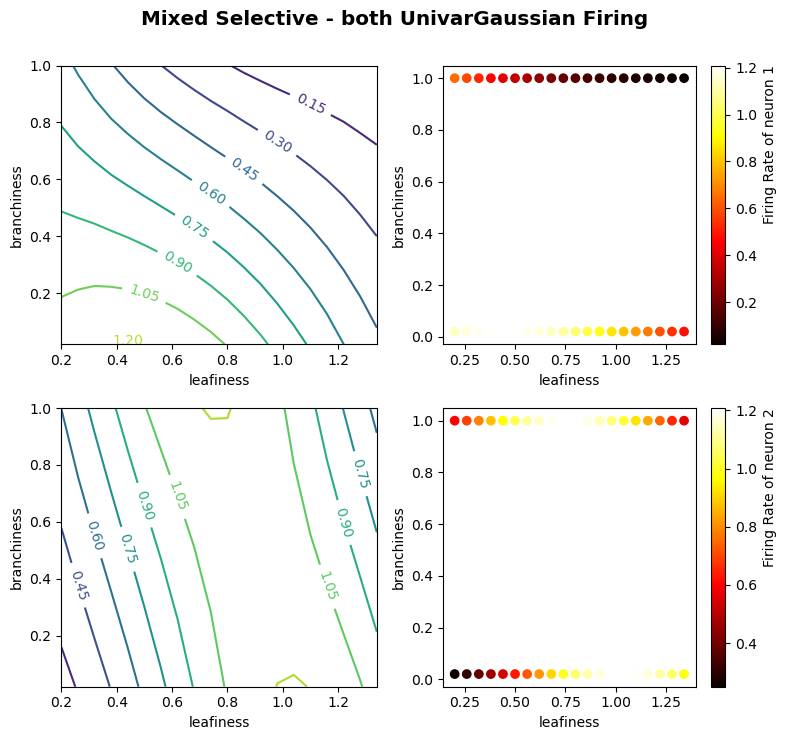

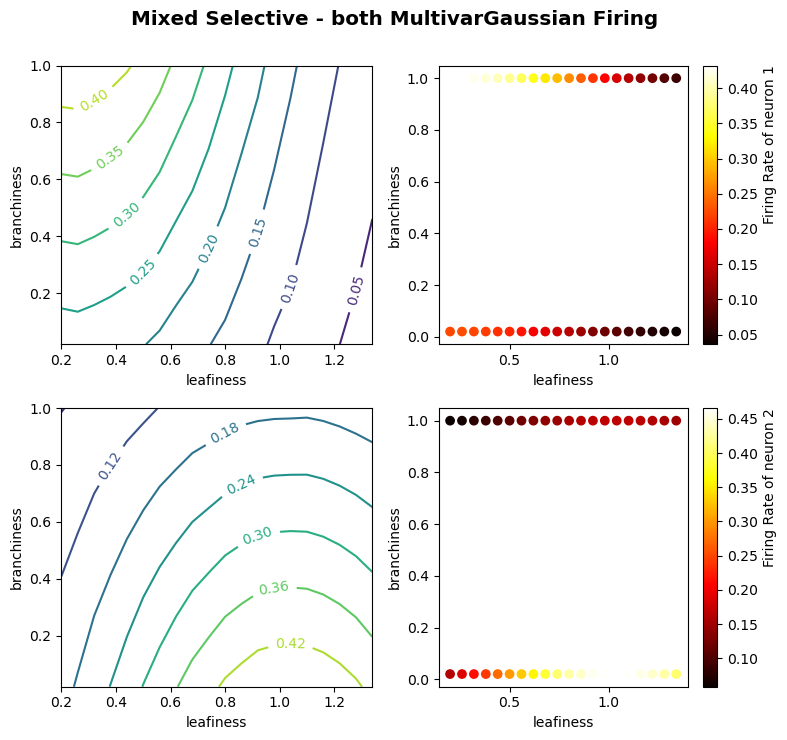

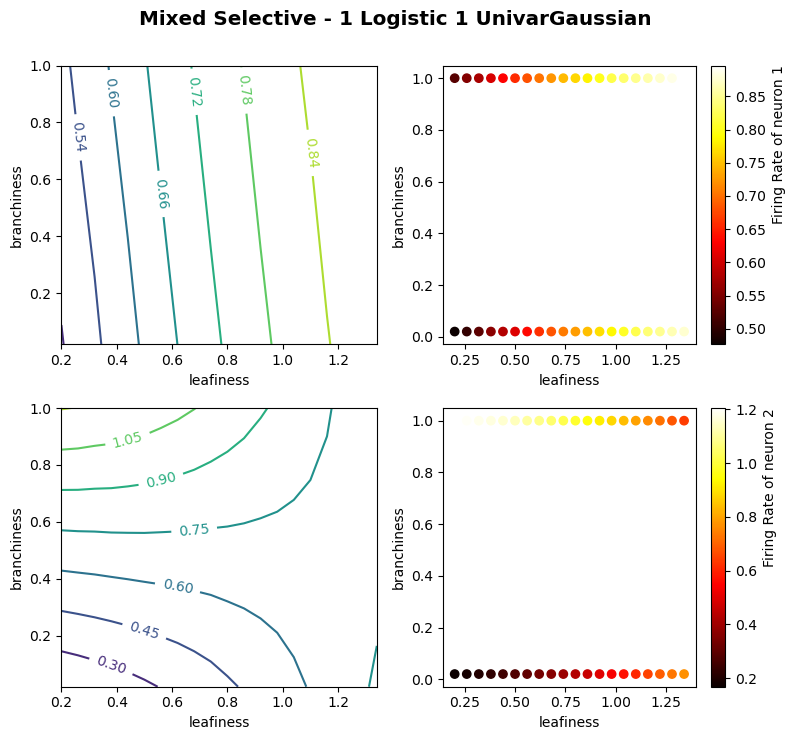

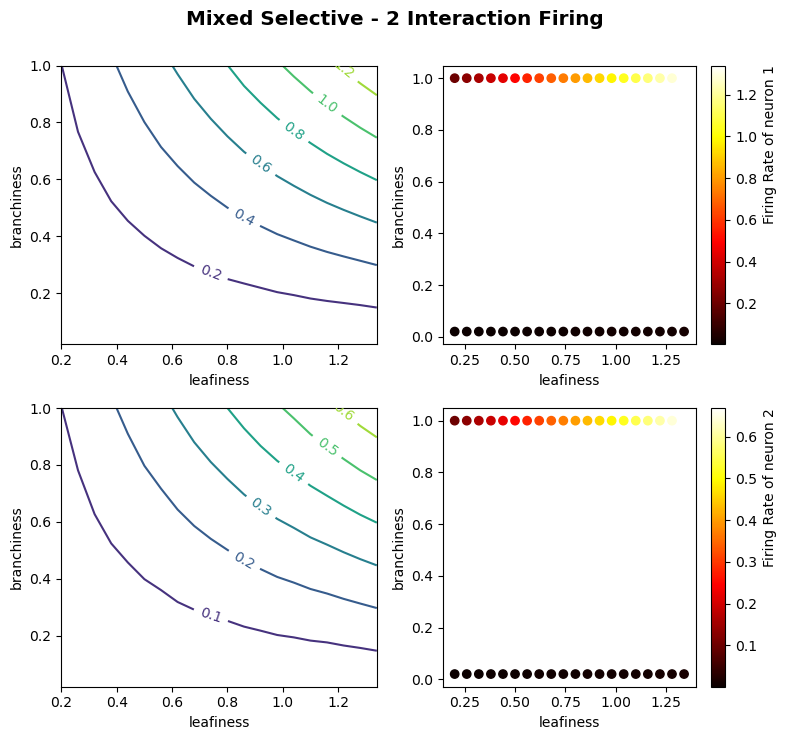

In [7]:
stim_space = deepcopy(Trees.stimuli)
new_shape=tuple([np.size(x) for x in Trees.features])
F1, F2 = np.reshape(stim_space[:,0],new_shape),np.reshape(stim_space[:,1],new_shape)
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    if s_name != "stimuli space":
        firing_space = s_mat
        fig, ax = plt.subplots(2,2,figsize=(8,7))
        for j in range(firing_space.shape[1]):
            H = np.reshape(firing_space[:,j],new_shape)
            cs=ax[j,0].contour(F1, F2, H)
            ax[j,0].clabel(cs, inline=True, fontsize=10)
            sc=ax[j,1].scatter(x=stim_space[:,0],y=stim_space[:,1],c=firing_space[:,j],cmap="hot")
            cbar = fig.colorbar(sc)
            cbar.set_label(f"Firing Rate of neuron {j+1}", loc='top')#
            ax[j,0].set_xlabel("leafiness")
            ax[j,1].set_xlabel("leafiness")
            ax[j,0].set_ylabel("branchiness")
            ax[j,1].set_ylabel("branchiness")
        fig.tight_layout()
        fig.suptitle(s_name,fontweight="bold",fontsize="x-large",position=(0.5,1.05))

explore PCA on different neurons

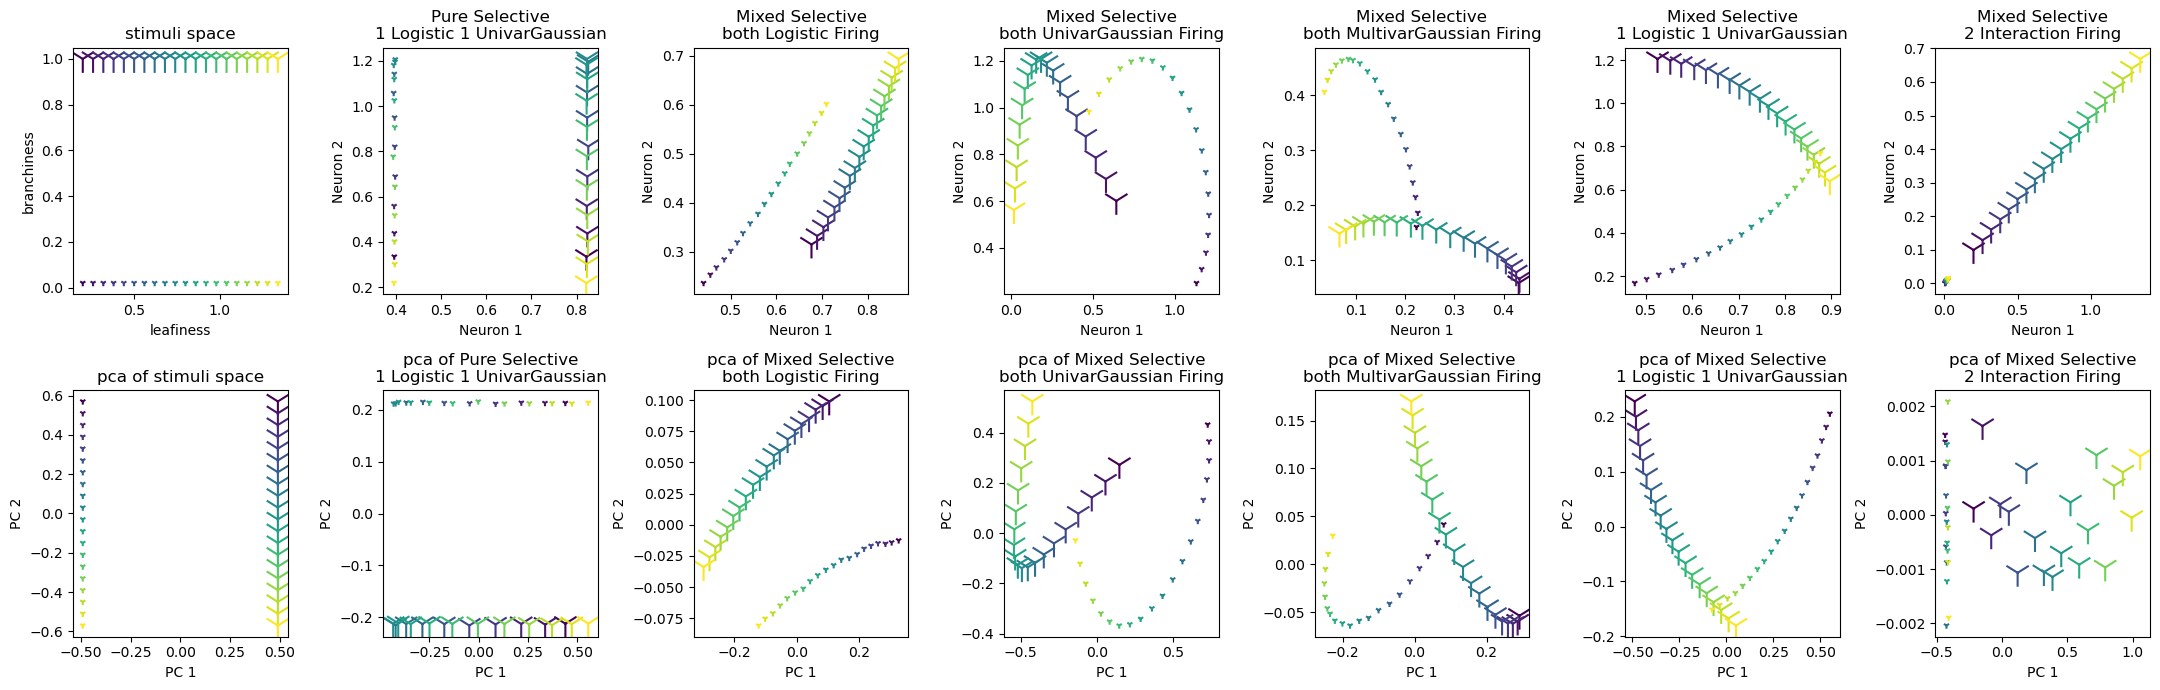

In [9]:
from sklearn.decomposition import PCA
pca_sapce = {}
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    pca_sapce |= {s_name:PCA(n_components=2).fit_transform(s_mat)}

fig_fspace,ax_fspace = plt.subplots(2,len(TwoNeuronSpaces),figsize=(3.1*len(TwoNeuronSpaces),7))
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    ax_fspace[0,js].scatter(x=s_mat[:,0],y=s_mat[:,1],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
    ax_fspace[0,js].set_title(s_name.replace(' - ','\n'))
    ax_fspace[1,js].scatter(x=pca_sapce[s_name][:,0],y=pca_sapce[s_name][:,1],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
    ax_fspace[1,js].set_title('pca of '+s_name.replace(' - ','\n'))
    if "stimuli" in s_name:
        ax_fspace[0,js].set_xlabel(Trees.featurenames[0])
        ax_fspace[0,js].set_ylabel(Trees.featurenames[1])
    else:
        ax_fspace[0,js].set_xlabel("Neuron 1")
        ax_fspace[0,js].set_ylabel("Neuron 2")
    ax_fspace[1,js].set_xlabel("PC 1")
    ax_fspace[1,js].set_ylabel("PC 2")
fig_fspace.tight_layout()